### 小売り顧客のクラスタリング

In [1]:
import pandas as pd

import japanize_matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# カラム名の日本語化
column_names = [
    "販売チャネル",
    "地域",
    "新鮮品",
    "乳製品",
    "食料品",
    "冷凍食品",
    "洗剤・紙製品",
    "惣菜",   
]

In [3]:
# データの読み込み
df = pd.read_csv('Wholesale customers data.csv', header=0, names=column_names)

In [4]:
df.head(10)

,販売チャネル,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


### データ確認

In [5]:
# データの形状確認
df.shape

(440, 8)

In [6]:
# 欠損値を確認
df.isnull().sum()

販売チャネル    0
地域        0
新鮮品       0
乳製品       0
食料品       0
冷凍食品      0
洗剤・紙製品    0
惣菜        0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   販売チャネル  440 non-null    int64
 1   地域      440 non-null    int64
 2   新鮮品     440 non-null    int64
 3   乳製品     440 non-null    int64
 4   食料品     440 non-null    int64
 5   冷凍食品    440 non-null    int64
 6   洗剤・紙製品  440 non-null    int64
 7   惣菜      440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [8]:
df.describe()

,販売チャネル,地域,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


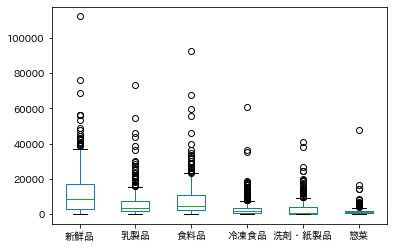

In [9]:
boxplot_df = df.drop(columns=["地域", "販売チャネル"])
boxplot_df.boxplot(grid=False)
plt.show()

### 3σ法により外れ値を処理

In [10]:
cleaned_df = boxplot_df.copy()
for column in boxplot_df.columns:
    # 平均と標準偏差を計算
    mean = cleaned_df[column].mean()
    std = cleaned_df[column].std()
    
    # 3σの範囲を計算
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    
    # 3σの範囲外のデータを除外
    cleaned_df = cleaned_df[(cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)]

In [11]:
# 削除されたデータ数を確認
print(cleaned_df.shape)
print(f'削除されたデータ数 {df.shape[0] - cleaned_df.shape[0]}')

(396, 6)
削除されたデータ数 44


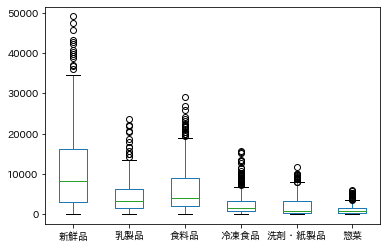

In [12]:
cleaned_df.boxplot(grid=False)
plt.show()

### エルボー法

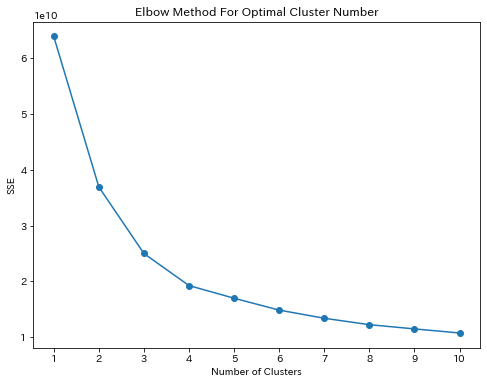

In [13]:
from sklearn.cluster import KMeans

# クラスタ数のリスト
cluster_range = range(1, 11)  # 1から10までのクラスタ数を試す

# 各クラスタ数でのSSEを保存するリスト
sse = []

# クラスタ数を変えながらKMeansクラスタリングを実行し、SSEを計算
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10,  random_state=0) #n_initで初期化を10回行う
    kmeans.fit(cleaned_df)
    sse.append(kmeans.inertia_)  # inertia_属性にはSSEが保存されている

# エルボー法のプロットを作成
plt.figure(figsize=(8,6))
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method For Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(cluster_range)
plt.show()

- エルボー法よりクラスター数は3が適切と判断

### k-meansによるクラスタリング

In [14]:
# モデル作成
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit_predict(cleaned_df);

In [15]:
# クラスタリング結果をデータフレームに追加
cleaned_df['Cluster_id'] = kmeans.fit_predict(cleaned_df)
cleaned_df

,新鮮品,乳製品,食料品,冷凍食品,洗剤・紙製品,惣菜,Cluster_id
0,12669,9656,7561,214,2674,1338,0
1,7057,9810,9568,1762,3293,1776,2
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,1
5,9413,8259,5126,666,1795,1451,0
...,...,...,...,...,...,...,...
434,16731,3922,7994,688,2371,838,1
435,29703,12051,16027,13135,182,2204,1
436,39228,1431,764,4510,93,2346,1
438,10290,1981,2232,1038,168,2125,0


### 結果の可視化

#### 積み上げ棒グラフによる可視化

[Text(0, 0, 'cluster0'), Text(1, 0, 'cluster1'), Text(2, 0, 'cluster2')]

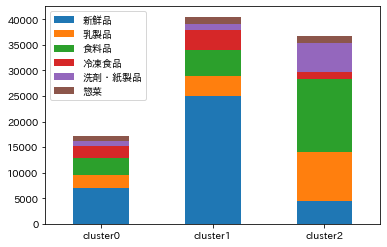

In [16]:
clusterinfo = pd.DataFrame()

# 各クラスタの平均値を計算
for i in range(3):
    clusterinfo['cluster' + str(i)] = cleaned_df[cleaned_df['Cluster_id'] == i].mean()
clusterinfo = clusterinfo.drop('Cluster_id')

my_plot = clusterinfo.T.plot(kind='bar', stacked=True)
my_plot.set_xticklabels(my_plot.xaxis.get_majorticklabels(), rotation=0)

- cluster0はほぼバランスよく商品を購入するが、売り上げは低い
- cluster1は新鮮品の購入が多く、売り上げが高い
- cluster2は食料品の購入が多く、2番目に売り上げが高い

#### 散布図による可視化

In [17]:
# PCAで2次元に削減
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(cleaned_df.drop('Cluster_id', axis=1))

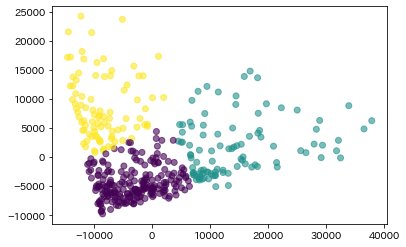

In [18]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cleaned_df['Cluster_id'], cmap='viridis', alpha=0.6)